In [1]:

import time

import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import functional as F
from torch.optim import Adam

from environments import PendulumEnv
from environments.pendulum import State
from environments.pendulum.state import size as state_size
from evaluators.direct_actor import SWITCH, NOP
from framework.agents.dqn_agent import DQNAgent
from shared_parameters import *
from utils import MLP, MemoryBuffer, running_average

torch.set_printoptions(sci_mode=False)

In [6]:
env = PendulumEnv(step_reward=1.0, action_cost=0.1, death_cost=100.0)

x = enemy_x


def get_starting_state():
    return State(bob_radius=bob_radius, max_angle=max_angle, connector_length=0.4, vertical_speed=0.05,
                 current_angle=current_angle, position=position, angular_speed=0.25,
                 enemy_radius=enemy_radius, enemy_x=x, enemy_y=enemy_y)


from environments.pendulum.state import enemy_x as s_enemy_x
from random import random

max_episode_length = 20

num_actions = 2
agent = DQNAgent(state_size, action_size=num_actions, hidden=[6, 8, 4],
                 optimizer_class=Adam, lr=0.01, polyak_factor=0.95, epsilon_steps=1000, discount_factor=0.995)

# Default starting state
start_state = get_starting_state()
memory = MemoryBuffer(capacity=10000)

epoch = 1


def train_network(verbose=False):
    global epoch
    training_sample = memory.sample(500)
    states, actions, rewards, next_states, dones = zip(*training_sample)

    states = torch.tensor(states)
    rewards = torch.tensor(rewards).unsqueeze(-1)
    next_states = torch.tensor(next_states)
    dones = torch.tensor(dones).unsqueeze(-1)

    loss = agent.update(states, actions, rewards, next_states, dones)

    if verbose:
        print(f"E. {epoch} Loss: {loss}. Epsilon: {agent.epsilon.value:>5.4f}")

    epoch += 1


total_rewards = []


def play_episode(verbose=True, render=False, train=True, use_epsilon=True, push_into_memory=True):
    episode = []

    # Randomize enemy position
    state = start_state
    state[s_enemy_x] = random() * (0.3 - -0.3) + -0.3

    step = 0
    done = False
    total_reward = 0
    while not done and step < max_episode_length:
        if render:
            env.render(state)
            time.sleep(0.01)

        action = agent.get_action(torch.from_numpy(state)).item()
        next_state, reward, done = env.transition(state, action)
        transition = state, action, reward, next_state, done

        if push_into_memory:
            memory.push(transition)

        episode.append(transition)

        total_reward += reward

        if train and memory.is_full:
            train_network(step == 0)

        state = next_state

        step += 1

    clear_output(True)
    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

    if verbose:
        print(f"Total reward: {total_reward}. Total average: {sum(total_rewards) / len(total_rewards)}")
    return episode


while not memory.is_full:
    play_episode(train=False)

try:
    train_network(verbose=True)
except KeyboardInterrupt:
    ...

Total reward: -90.5. Total average: -64.78182957393484
E. 1 Loss: 582.5314331054688. Epsilon: 1.0000


Total reward: 18.8. Total average: -22.46849999999996


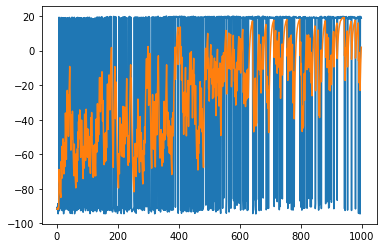

In [15]:
try:
    for i in range(100):
        play_episode(render=False)

    plt.plot(total_rewards)
    plt.plot(running_average(total_rewards))
    plt.show()
except KeyboardInterrupt:
    ...

Once we're satisfied with the quality of our Q-network,
we can use it to infer the difficulty of the environment.

    Actually, we can also infer the difficulty without a trained Q-netwrok,
    the only difference is the quality of predictions. Untrained Q-network
    can (but not always) behave as an agent who does not know how to play the game.

Let's now estimate the difficulty of a single episode:

1. The difficulty of an episode is an aggregated difficulty of the individual states
2. The difficulty of a state is the difference between the maximum Q-value, from the
   average of the Q-values of the state

We also need to keep the Q-values normalized. The normalization occurs w.r.t. the
maximum and minimum Q-values, experienced by a single agent with its own Q-network.

In [ ]:
# Initialize the minimum and maximum Q-values
q_min, q_max = float("inf"), float("-inf")

In [ ]:
episode = play_episode(verbose=True, render=False, train=False, use_epsilon=False, push_into_memory=False)
print()

states, *_ = zip(*episode)
states = torch.tensor(states)

with torch.no_grad():
    q_values = agent.get_q_values(states)

    print("Q-values")
    print(q_values)
    print()

    # Update the bounds
    q_min = min(q_min, q_values.min())
    q_max = max(q_max, q_values.max())

    # Normalize
    q_values = (q_values - q_min) / (q_max - q_min)

    print("Q-values (normalized)")
    print(q_values)
    print()

    difficulties = q_values.max(dim=-1)[0] - q_values.mean(dim=-1)

    print("Difficulties")
    print(difficulties)
    print()

    trajectory_difficulty = difficulties.mean()
    print(f"Trajectory difficulty = {trajectory_difficulty:.6f}")

We can now use this as another method of difficulty estimation